In [44]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [191]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import itertools

import sklearn.linear_model as skl_lm
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV

import statsmodels.api as sm
import matplotlib.pyplot as plt

import seaborn as sns
import time

from patsy import dmatrix

pd.set_option('display.max_rows', 100)
plt.rcParams["figure.figsize"] = (20,10)
pd.options.display.max_rows = 500

In [128]:
pd.read_json('raw_comp_data.json').to_csv('raw_comp_data.csv')
comp_raw = pd.read_csv('raw_comp_data.csv', index_col="rowNumber")
comp_raw.dtypes
comp_raw

Unnamed: 0                   int64
timestamp                   object
company                     object
level                       object
title                       object
totalyearlycompensation    float64
location                    object
yearsofexperience          float64
yearsatcompany             float64
tag                         object
basesalary                 float64
stockgrantvalue            float64
bonus                      float64
gender                      object
otherdetails                object
cityid                     float64
dmaid                      float64
dtype: object

,Unnamed: 0,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,otherdetails,cityid,dmaid
rowNumber,,,,,,,,,,,,,,,,,
1,0,2017-06-07 11:33:27,Oracle,L3,Product Manager,127.0,"Redwood City, CA",1.5,1.5,NaN,107.0,20.0,10.0,NaN,NaN,7392.0,807.0
2,1,2017-06-10 17:11:29,eBay,SE 2,Software Engineer,100.0,"San Francisco, CA",5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,7419.0,807.0
3,2,2017-06-11 14:53:57,Amazon,L7,Product Manager,310.0,"Seattle, WA",8.0,0.0,NaN,155.0,NaN,NaN,NaN,NaN,11527.0,819.0
4,3,2017-06-13 05:35:36,Uber,Senior,Software Engineer,578.0,"San Francisco, CA",10.0,2.0,NaN,180000.0,1550000.0,9000.0,NaN,Stock based on $48.65 per share.,7419.0,807.0
5,4,2017-06-14 21:22:25,Microsoft,64,Software Engineering Manager,200.0,"Redmond, WA",9.0,9.0,NaN,169000.0,100000.0,30000.0,NaN,NaN,11521.0,819.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30139,24748,2020-06-05 08:52:54,Twitter,Senior SWE,Software Engineer,370.0,"New York, NY",10.0,6.0,iOS,187.0,150.0,33.0,Male,NaN,10182.0,501.0
30140,24749,2020-06-05 09:19:09,Bloomberg,Senior Software Engineer,Software Engineer,212.0,"New York, NY",2.0,0.0,Distributed Systems (Back-End),177.0,0.0,35.0,Male,25k signing,10182.0,501.0
30142,24750,2020-06-05 09:53:21,Google,L4,Software Engineer,185.0,"London, EN, United Kingdom",4.0,2.0,API Development (Back-End),98.0,57.0,30.0,Male,NaN,12008.0,0.0


In [154]:
comp_renamed = comp_raw.rename(columns={
    "totalyearlycompensation": "raw_total_comp",
    "basesalary": "raw_salary",
    "stockgrantvalue": "raw_stock",
    "bonus": "raw_bonus",
    "yearsofexperience": "years_experience",
    "yearsatcompany": "years_company",
})
comp_renamed = pd.concat([
    comp_renamed.raw_total_comp,
    comp_renamed.raw_salary,
    comp_renamed.raw_stock,
    comp_renamed.raw_bonus,
    comp_renamed.drop(columns=['raw_total_comp', 'raw_salary', 'raw_stock', 'raw_bonus'])
], axis=1)
comp_renamed = comp_renamed.drop(columns=['cityid', 'dmaid', 'Unnamed: 0'])
comp_renamed.index.rename("entry_id", inplace=True)
comp_renamed

,raw_total_comp,raw_salary,raw_stock,raw_bonus,timestamp,company,level,title,location,years_experience,years_company,tag,gender,otherdetails
entry_id,,,,,,,,,,,,,,
1,127.0,107.0,20.0,10.0,2017-06-07 11:33:27,Oracle,L3,Product Manager,"Redwood City, CA",1.5,1.5,NaN,NaN,NaN
2,100.0,NaN,NaN,NaN,2017-06-10 17:11:29,eBay,SE 2,Software Engineer,"San Francisco, CA",5.0,3.0,NaN,NaN,NaN
3,310.0,155.0,NaN,NaN,2017-06-11 14:53:57,Amazon,L7,Product Manager,"Seattle, WA",8.0,0.0,NaN,NaN,NaN
4,578.0,180000.0,1550000.0,9000.0,2017-06-13 05:35:36,Uber,Senior,Software Engineer,"San Francisco, CA",10.0,2.0,NaN,NaN,Stock based on $48.65 per share.
5,200.0,169000.0,100000.0,30000.0,2017-06-14 21:22:25,Microsoft,64,Software Engineering Manager,"Redmond, WA",9.0,9.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30139,370.0,187.0,150.0,33.0,2020-06-05 08:52:54,Twitter,Senior SWE,Software Engineer,"New York, NY",10.0,6.0,iOS,Male,NaN
30140,212.0,177.0,0.0,35.0,2020-06-05 09:19:09,Bloomberg,Senior Software Engineer,Software Engineer,"New York, NY",2.0,0.0,Distributed Systems (Back-End),Male,25k signing
30142,185.0,98.0,57.0,30.0,2020-06-05 09:53:21,Google,L4,Software Engineer,"London, EN, United Kingdom",4.0,2.0,API Development (Back-End),Male,NaN


In [202]:
comp_swe = comp_renamed[comp_renamed['title'] == 'Software Engineer']
comp_swe = comp_swe.dropna(subset=['raw_salary'])
comp_swe = comp_swe.fillna(value={'raw_stock': 0, 'raw_bonus': 0})
comp_swe

,raw_total_comp,raw_salary,raw_stock,raw_bonus,timestamp,company,level,title,location,years_experience,years_company,tag,gender,otherdetails
entry_id,,,,,,,,,,,,,,
4,578.0,180000.0,1550000.0,9000.0,2017-06-13 05:35:36,Uber,Senior,Software Engineer,"San Francisco, CA",10.0,2.0,NaN,NaN,Stock based on $48.65 per share.
6,173.0,120000.0,0.0,53000.0,2017-06-16 10:44:01,Amazon,L5,Software Engineer,"Vancouver, BC, Canada",11.0,1.0,NaN,NaN,NaN
8,270.0,160.0,0.0,0.0,2017-06-18 23:37:21,Facebook,E4,Software Engineer,"Menlo Park, CA",3.5,2.0,NaN,NaN,NaN
10,190.0,110000.0,80000.0,0.0,2017-06-20 18:49:59,Amazon,L5,Software Engineer,"Seattle, WA",3.0,3.0,NaN,NaN,NaN
13,156.0,135.0,8.0,13.0,2017-06-22 13:55:26,Microsoft,62,Software Engineer,"Seattle, WA",4.0,4.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30133,115.0,115.0,0.0,0.0,2020-06-05 04:13:25,IBM,Advisory Engineer,Software Engineer,"Madison, WI",6.0,1.0,Distributed Systems (Back-End),Male,Masters
30139,370.0,187.0,150.0,33.0,2020-06-05 08:52:54,Twitter,Senior SWE,Software Engineer,"New York, NY",10.0,6.0,iOS,Male,NaN
30140,212.0,177.0,0.0,35.0,2020-06-05 09:19:09,Bloomberg,Senior Software Engineer,Software Engineer,"New York, NY",2.0,0.0,Distributed Systems (Back-End),Male,25k signing


In [203]:
# OUTPUT IMPLICATIONS
# Total comp is already scaled down to 1000's number
# Maximum total comp is $2.5m
comp_swe[comp_swe.raw_total_comp > 999].sort_values(by='raw_total_comp', ascending=False)

,raw_total_comp,raw_salary,raw_stock,raw_bonus,timestamp,company,level,title,location,years_experience,years_company,tag,gender,otherdetails
entry_id,,,,,,,,,,,,,,
12694,2500.0,350.0,1500.0,650.0,2019-07-31 22:52:33,Microsoft,69,Software Engineer,"Redmond, WA",11.0,11.0,ML / AI,Female,NaN
21423,2400.0,500.0,1800.0,100.0,2020-01-30 15:13:18,Doordash,E7,Software Engineer,"Seattle, WA",20.0,2.0,ML / AI,NaN,NaN
9041,2221.0,275.0,1867.0,79.0,2019-05-23 13:45:55,Facebook,E7,Software Engineer,"New York, NY",8.0,6.0,Full Stack,Male,NaN
11377,1800.0,350.0,700.0,750.0,2019-07-02 15:05:10,Facebook,E8,Software Engineer,"Menlo Park, CA",31.0,11.0,Security,Male,NaN
28380,1800.0,300.0,1400.0,100.0,2020-05-11 21:51:56,Google,L8,Software Engineer,"Seattle, WA",15.0,10.0,ML / AI,Male,PhD
8202,1750.0,200.0,1200.0,350.0,2019-04-27 21:44:39,Google,Distinguished Engineer,Software Engineer,"Mountain View, CA",22.0,18.0,Security,Male,NaN
14822,1630.0,330.0,1150.0,150.0,2019-09-15 09:55:05,Google,L8,Software Engineer,"Mountain View, CA",16.0,12.0,ML / AI,Male,NaN
248,1500.0,300.0,1150.0,50.0,2018-01-27 07:29:30,Uber,L6,Software Engineer,"San Francisco, CA",15.0,3.0,NaN,NaN,NaN
7029,1450.0,300.0,1085.0,65.0,2019-03-24 20:15:29,Facebook,E8,Software Engineer,"Menlo Park, CA",7.0,5.0,ML / AI,Male,NaN


In [204]:
# OUTPUT IMPLICATION
# Salary needs to be scaled down for all values above 5,000
# Maximum SCALED salary is $750k from Netflix
# Entry 13778 needs to be dropped
# Entry 322 and 889 salaries need to fixed or dropped
comp_swe[comp_swe.raw_salary > 700].sort_values(by='raw_salary', ascending=False)

,raw_total_comp,raw_salary,raw_stock,raw_bonus,timestamp,company,level,title,location,years_experience,years_company,tag,gender,otherdetails
entry_id,,,,,,,,,,,,,,
322,300.0,2000000.0,45000.0,55000.0,2018-02-19 19:14:29,Intel,Principal engineer,Software Engineer,"Hillsboro, OR",22.0,20.0,NaN,NaN,NaN
889,162.0,1620000.0,0.0,0.0,2018-06-12 05:04:06,Squarespace,Senior I,Software Engineer,"New York, NY",7.0,7.0,API Development (Back-End),Male,"Lots of vested ISOs, some fresh RSUs, illiquid."
2177,630.0,600000.0,30.0,0.0,2018-09-20 22:40:58,Netflix,Senior Software Engineer,Software Engineer,"Los Gatos, CA",10.0,1.0,Distributed Systems (Back-End),NaN,NaN
12194,440.0,425000.0,21000.0,0.0,2019-07-21 17:26:13,Netflix,Senior Software Engineer,Software Engineer,"Los Gatos, CA",7.0,0.0,Distributed Systems (Back-End),Male,NaN
11988,430.0,410000.0,20500.0,0.0,2019-07-16 21:41:33,Netflix,Senior Software Engineer,Software Engineer,"Los Gatos, CA",10.0,2.0,Distributed Systems (Back-End),Male,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,145.0,12000.0,5000.0,20000.0,2018-03-06 18:50:18,Amazon,L4,Software Engineer,"Seattle, WA",3.0,0.6,NaN,NaN,NaN
615,133.0,12000.0,0.0,13.0,2018-05-10 17:50:23,NetApp,MTS III,Software Engineer,"Pittsburgh, PA",6.0,3.0,NaN,Male,NaN
8266,120.0,10000.0,0.0,20000.0,2019-04-30 16:09:30,USAA,Software Engineer I,Software Engineer,"Phoenix, AZ",8.0,0.0,API Development (Back-End),Male,NaN


In [194]:
# OUTPUT IMPLICATION
# Stock CAN be scaled down for all values above 1,250 (See entry 444)
# Some stock inputs are inconsistent with salary or bonus scaling choice
comp_swe[(comp_swe.raw_stock > 999) & (comp_swe.raw_stock < 1e4)].sort_values(by='raw_stock', ascending=False)

,raw_total_comp,raw_salary,raw_stock,raw_bonus,timestamp,company,level,title,location,years_experience,years_company,tag,gender,otherdetails
entry_id,,,,,,,,,,,,,,
1485,240.000,156.0,9720.0,77.0,2018-08-16 08:38:48,Amazon,L5,Software Engineer,"Seattle, WA",2.0,0.0,API Development (Back-End),NaN,NaN
987,130.000,118000.0,9365.0,11000.0,2018-06-25 17:28:00,Intuit,2,Software Engineer,"San Francisco, CA",3.0,2.0,Web Development (Front-End),Female,NaN
159,155.000,129000.0,9000.0,17000.0,2017-11-25 22:35:02,Microsoft,61,Software Engineer,"Redmond, WA",3.0,3.0,NaN,NaN,NaN
654,157.056,133956.0,9000.0,14100.0,2018-05-16 16:34:37,Microsoft,61,Software Engineer,"Seattle, WA",4.0,4.0,NaN,Male,NaN
633,193.000,155000.0,8000.0,30000.0,2018-05-13 07:26:37,Intel,Grade 8,Software Engineer,"Santa Clara, CA",4.0,1.0,NaN,Female,NaN
5861,116.000,108.0,8000.0,NaN,2019-02-13 12:28:11,Oracle,IC-2,Software Engineer,"San Jose, CA",3.0,3.0,Full Stack,Male,NaN
703,180.000,130000.0,8000.0,20000.0,2018-05-22 09:24:16,Microsoft,61,Software Engineer,"Seattle, WA",3.0,3.0,NaN,Male,NaN
1589,157.000,134000.0,8000.0,15000.0,2018-08-21 10:13:59,Microsoft,61,Software Engineer,"Seattle, WA",3.0,3.0,Firmware,NaN,NaN
1219,151.000,113000.0,7500.0,30000.0,2018-07-28 15:23:19,Amazon,L4,Software Engineer,"Palo Alto, CA",1.0,1.0,Full Stack,Male,NaN


In [198]:
# OUTPUT IMPLICATION
# Bonus should be scaled down for all values above 999 (See entry 995)
# Some bonus inputs are inconsistent with salary or stock scaling choice
comp_swe[(comp_swe.raw_bonus > 499) & (comp_swe.raw_bonus < 1e4)].sort_values(by='raw_bonus', ascending=False)

,raw_total_comp,raw_salary,raw_stock,raw_bonus,timestamp,company,level,title,location,years_experience,years_company,tag,gender,otherdetails
entry_id,,,,,,,,,,,,,,
720,129.0,95000.0,20000.0,9500.0,2018-05-24 11:25:11,Intuit,SE1,Software Engineer,"San Francisco, CA",0.0,1.0,NaN,Male,NaN
335,109.0,93420.0,6250.0,9342.0,2018-02-25 18:00:15,eBay,SE 2,Software Engineer,"Portland, OR",1.0,1.0,NaN,NaN,NaN
1524,131.0,119.0,2700.0,9300.0,2018-08-17 13:09:01,Microsoft,60,Software Engineer,"Redmond, WA",2.0,2.0,Full Stack,NaN,NaN
471,71.0,62000.0,NaN,9300.0,2018-04-11 08:16:35,USAA,New Grad,Software Engineer,"San Antonio, TX",0.0,0.0,NaN,NaN,NaN
4,578.0,180000.0,1550000.0,9000.0,2017-06-13 05:35:36,Uber,Senior,Software Engineer,"San Francisco, CA",10.0,2.0,NaN,NaN,Stock based on $48.65 per share.
14272,72.0,63000.0,NaN,9000.0,2019-09-08 16:30:34,USAA,Software Engineer III,Software Engineer,"San Antonio, TX",0.0,0.0,Full Stack,Male,"Java, Javascript"
13143,88.0,79200.0,NaN,8500.0,2019-08-14 15:42:30,General Motors,L5,Software Engineer,"Detroit, MI",3.0,2.0,Full Stack,Male,NaN
505,240.0,158.0,70.0,8500.0,2018-04-18 19:03:22,Adobe,L4/Computer Scientist II,Software Engineer,"New York, NY",7.0,1.0,NaN,Male,NaN
1169,145.0,110000.0,27000.0,8000.0,2018-07-20 12:01:00,Qualcomm,senior,Software Engineer,"San Diego, CA",4.0,4.0,NaN,Male,NaN


In [213]:
normalized_total_comp = comp_swe.raw_total_comp.rename('total_comp')

In [214]:
def comp_salary_scaler(salary):
    if salary > 5e3:
        return salary / 1e3
    return salary

normalized_salary = comp_swe.raw_salary.apply(comp_salary_scaler).rename('salary')

In [216]:
def comp_bonus_scaler(bonus):
    if bonus > 999:
        return bonus / 1e3
    return bonus

normalized_bonus = comp_swe.raw_bonus.apply(comp_bonus_scaler).rename('bonus')

In [224]:
# Correctness requires that everything is scaled down to 1000's value
def comp_is_consistent(total_comp, salary, stock, bonus):
    return np.absolute(total_comp - (salary + stock + bonus)) <= 20

stocks = []
for entry in comp_swe.itertuples():
    index = entry.Index
    stock = comp_swe.raw_stock[index]
    
    total_comp = normalized_total_comp[index]
    salary = normalized_salary[index]
    bonus = normalized_bonus[index]
    
    consistent_stock = np.nan
    if comp_is_consistent(total_comp, salary, stock, bonus):
        consistent_stock = stock
    elif comp_is_consistent(total_comp, salary, stock / 4.0, bonus):
        consistent_stock = stock / 4.0
    elif comp_is_consistent(total_comp, salary, stock / 1e3, bonus):
        consistent_stock = stock / 1e3
    elif comp_is_consistent(total_comp, salary, stock / 4e3, bonus):
        consistent_stock = stock / 4e3
        
    stocks.append(consistent_stock)

normalized_stock = pd.Series(data=stocks, index=comp_swe.index).rename('stock')
normalized_stock

entry_id
4        387.5
6          0.0
8          NaN
10        80.0
13         8.0
         ...  
30133      0.0
30139    150.0
30140      0.0
30142     57.0
30143     55.0
Name: stock, Length: 14808, dtype: float64

In [225]:
#stock = comp_swe.raw_stock.apply(comp_large_reduction).rename('stock')
#stock = comp_swe.raw_stock.rename('stock')

# def comp_entry_is_valid(entry):
#     actual_total_comp = entry.total_comp * 1000 if entry.total_comp < 1e3 else entry.total_comp
#     actual_salary = entry.salary * 1000 if entry.salary < 1e3 else entry.salary
#     actual_stock = entry.stock * 1000 if entry.stock < 1e3 else entry.stock
#     actual_bonus = entry.bonus * 1000 if entry.bonus < 1e3 else entry.bonus
    
#     if np.absolute(actual_total_comp - (actual_salary + actual_stock + actual_bonus)) > 2e4:
#         return False
    
#     return True

In [240]:
comp_normalized = pd.concat([
    normalized_total_comp,
    normalized_salary,
    normalized_stock,
    normalized_bonus,
    comp_swe
], axis=1)
comp_normalized = comp_normalized.drop(columns=['raw_total_comp', 'raw_salary', 'raw_stock', 'raw_bonus'])
comp_normalized = comp_normalized.dropna(subset=['stock'])
comp_normalized

,total_comp,salary,stock,bonus,timestamp,company,level,title,location,years_experience,years_company,tag,gender,otherdetails
entry_id,,,,,,,,,,,,,,
4,578.0,180.0,387.5,9.0,2017-06-13 05:35:36,Uber,Senior,Software Engineer,"San Francisco, CA",10.0,2.0,NaN,NaN,Stock based on $48.65 per share.
6,173.0,120.0,0.0,53.0,2017-06-16 10:44:01,Amazon,L5,Software Engineer,"Vancouver, BC, Canada",11.0,1.0,NaN,NaN,NaN
10,190.0,110.0,80.0,0.0,2017-06-20 18:49:59,Amazon,L5,Software Engineer,"Seattle, WA",3.0,3.0,NaN,NaN,NaN
13,156.0,135.0,8.0,13.0,2017-06-22 13:55:26,Microsoft,62,Software Engineer,"Seattle, WA",4.0,4.0,NaN,NaN,NaN
16,201.0,157.0,26.0,28.0,2017-06-26 21:25:45,Microsoft,63,Software Engineer,"Seattle, WA",12.0,6.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30133,115.0,115.0,0.0,0.0,2020-06-05 04:13:25,IBM,Advisory Engineer,Software Engineer,"Madison, WI",6.0,1.0,Distributed Systems (Back-End),Male,Masters
30139,370.0,187.0,150.0,33.0,2020-06-05 08:52:54,Twitter,Senior SWE,Software Engineer,"New York, NY",10.0,6.0,iOS,Male,NaN
30140,212.0,177.0,0.0,35.0,2020-06-05 09:19:09,Bloomberg,Senior Software Engineer,Software Engineer,"New York, NY",2.0,0.0,Distributed Systems (Back-End),Male,25k signing


,total_comp,salary,stock,bonus,timestamp,company,level,title,location,years_experience,years_company,tag,gender,otherdetails
entry_id,,,,,,,,,,,,,,
16438,750.0,750.0,0.0,0.0,2019-10-18 13:57:18,Netflix,Senior Software Engineer,Software Engineer,"Los Gatos, CA",15.0,7.0,Security,Male,+5% into stock option plan
3486,990.0,650.0,250.0,90.0,2018-11-01 01:06:12,Google,L9 / L10,Software Engineer,"Chicago, IL",20.0,15.0,ML / AI,NaN,NaN
2177,630.0,600.0,30.0,0.0,2018-09-20 22:40:58,Netflix,Senior Software Engineer,Software Engineer,"Los Gatos, CA",10.0,1.0,Distributed Systems (Back-End),NaN,NaN
29811,600.0,600.0,3.0,0.0,2020-05-31 09:24:42,Netflix,Senior,Software Engineer,"Los Gatos, CA",9.0,4.0,Distributed Systems (Back-End),NaN,NaN
8645,630.0,600.0,30.0,0.0,2019-05-12 13:25:58,Netflix,Senior Software Engineer,Software Engineer,"Los Gatos, CA",12.0,3.0,Full Stack,Male,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18235,10.0,5.0,0.0,0.0,2019-11-28 13:47:26,Andela,E1,Software Engineer,"Lagos, LA, Nigeria",5.0,1.0,Full Stack,Male,NaN
29059,10.0,5.0,0.0,1.0,2020-05-20 17:44:06,Accenture,Software Engineer Analyst,Software Engineer,"Bangalore, KA, India",2.0,2.0,Web Development (Front-End),Male,NaN
16379,10.0,5.0,0.0,0.0,2019-10-17 01:59:32,Andela,E1,Software Engineer,"Lagos, LA, Nigeria",5.0,1.0,Full Stack,NaN,NaN


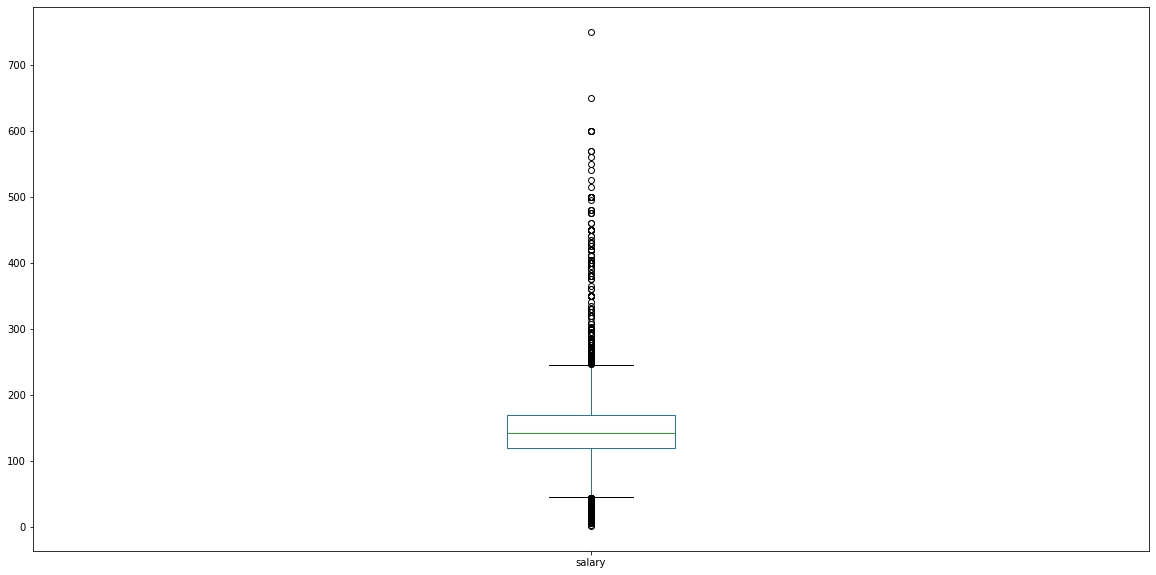

In [241]:
comp_normalized.salary.plot.box()
comp_normalized.sort_values(by='salary', ascending=False)

,total_comp,salary,stock,bonus,timestamp,company,level,title,location,years_experience,years_company,tag,gender,otherdetails
entry_id,,,,,,,,,,,,,,
9041,2221.0,275.0,1867.0,79.0,2019-05-23 13:45:55,Facebook,E7,Software Engineer,"New York, NY",8.0,6.0,Full Stack,Male,NaN
21423,2400.0,500.0,1800.0,100.0,2020-01-30 15:13:18,Doordash,E7,Software Engineer,"Seattle, WA",20.0,2.0,ML / AI,NaN,NaN
12694,2500.0,350.0,1500.0,650.0,2019-07-31 22:52:33,Microsoft,69,Software Engineer,"Redmond, WA",11.0,11.0,ML / AI,Female,NaN
28380,1800.0,300.0,1400.0,100.0,2020-05-11 21:51:56,Google,L8,Software Engineer,"Seattle, WA",15.0,10.0,ML / AI,Male,PhD
8202,1750.0,200.0,1200.0,350.0,2019-04-27 21:44:39,Google,Distinguished Engineer,Software Engineer,"Mountain View, CA",22.0,18.0,Security,Male,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26797,158.0,112.0,0.0,46.0,2020-04-16 21:46:07,Ibm,Senior,Software Engineer,"Austin, TX",3.0,1.0,Full Stack,NaN,NaN
26795,160.0,160.0,0.0,1.0,2020-04-16 20:57:51,IBM,9,Software Engineer,"San Antonio, TX",9.0,3.0,API Development (Back-End),Male,25K signing bonus
19660,132.0,120.0,0.0,12.0,2020-01-04 09:38:53,Chewy,SE2,Software Engineer,"Boston, MA",9.0,1.0,Full Stack,Male,NaN


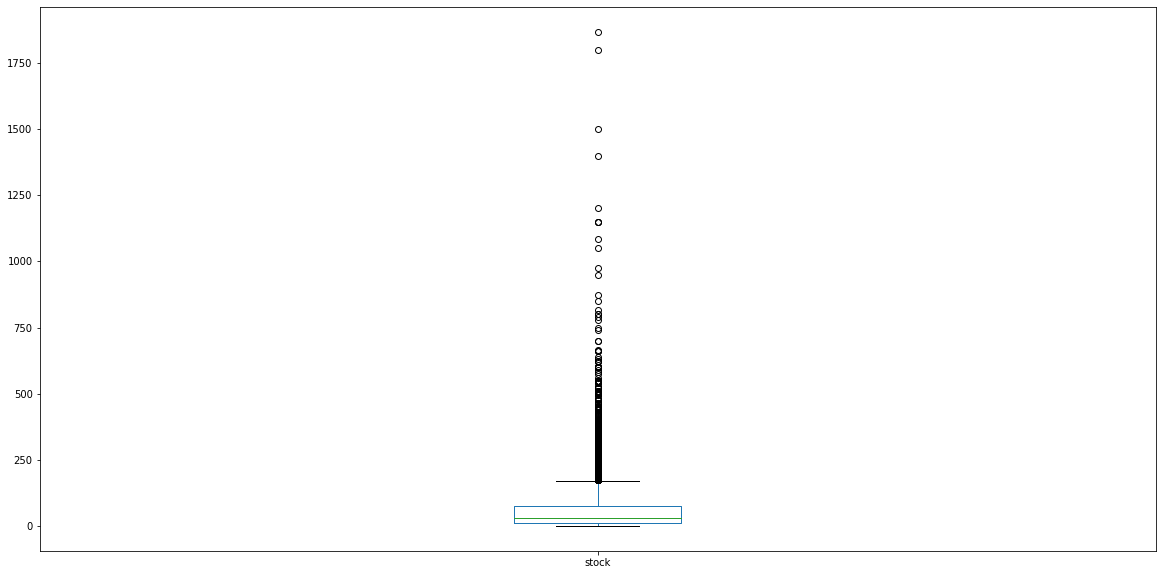

In [242]:
comp_normalized.stock.plot.box()
comp_normalized.sort_values(by='stock', ascending=False)

,total_comp,salary,stock,bonus,timestamp,company,level,title,location,years_experience,years_company,tag,gender,otherdetails
entry_id,,,,,,,,,,,,,,
11377,1800.0,350.0,700.0,750.0,2019-07-02 15:05:10,Facebook,E8,Software Engineer,"Menlo Park, CA",31.0,11.0,Security,Male,NaN
12694,2500.0,350.0,1500.0,650.0,2019-07-31 22:52:33,Microsoft,69,Software Engineer,"Redmond, WA",11.0,11.0,ML / AI,Female,NaN
10662,1030.0,400.0,0.0,630.0,2019-06-18 17:00:28,Jane Street Capital,Software Engineer,Software Engineer,"New York, NY",7.0,4.0,Distributed Systems (Back-End),Male,NaN
12829,720.0,200.0,20.0,500.0,2019-08-05 11:16:26,Argo AI,5,Software Engineer,"Princeton, NJ",5.0,1.0,ML / AI,Male,non-tradable stock
17707,680.0,160.0,45.0,475.0,2019-11-16 15:49:12,Amazon,L7,Software Engineer,"Seattle, WA",20.0,0.0,ML / AI,Female,Masters
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20387,195.0,142.0,50.0,0.0,2020-01-17 07:51:56,Amazon,SDE II,Software Engineer,"Boston, MA",3.0,3.0,Full Stack,Male,NaN
20384,10.0,9.0,0.0,0.0,2020-01-17 07:30:41,Andela,ENG 1,Software Engineer,"Nairobi, NA, Kenya",3.0,3.5,API Development (Back-End),Male,"Salary is actually $9,800 a year but forma val..."
20380,600.0,210.0,390.0,0.0,2020-01-17 05:48:05,Snap,L5,Software Engineer,"Seattle, WA",15.0,1.0,Full Stack,Male,PhD


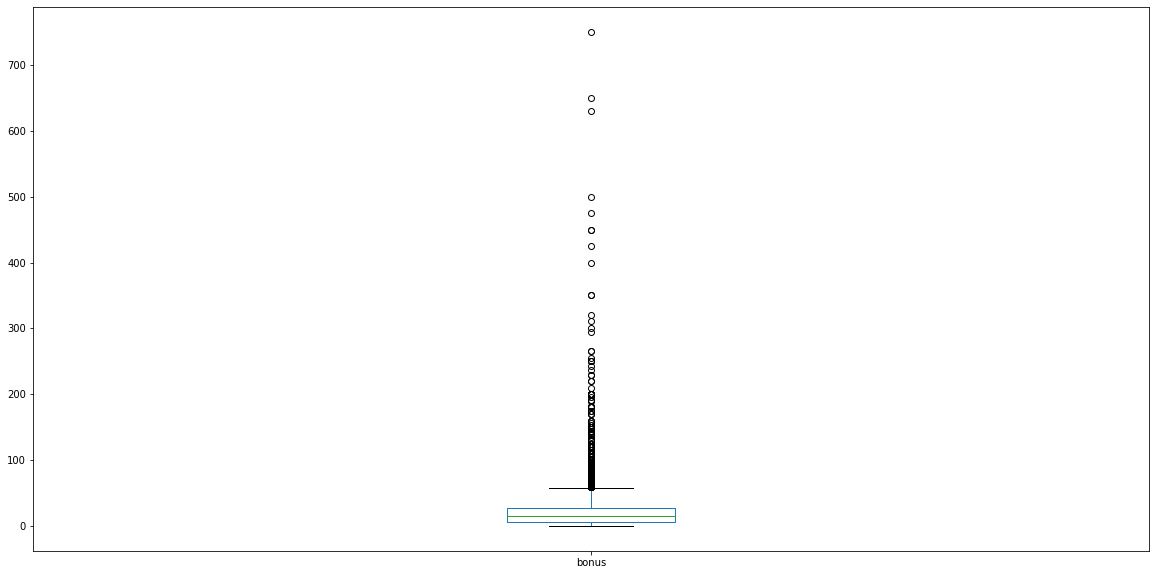

In [243]:
comp_normalized.bonus.plot.box()
comp_normalized.sort_values(by='bonus', ascending=False)

In [244]:
comp_normalized.isna().sum(axis=0)

total_comp              0
salary                  0
stock                   0
bonus                   0
timestamp               0
company                 0
level                   6
title                   0
location                0
years_experience        0
years_company           0
tag                   476
gender               3303
otherdetails        10853
dtype: int64

In [246]:
comp_normalized.to_csv('normalized_comp_data.csv')

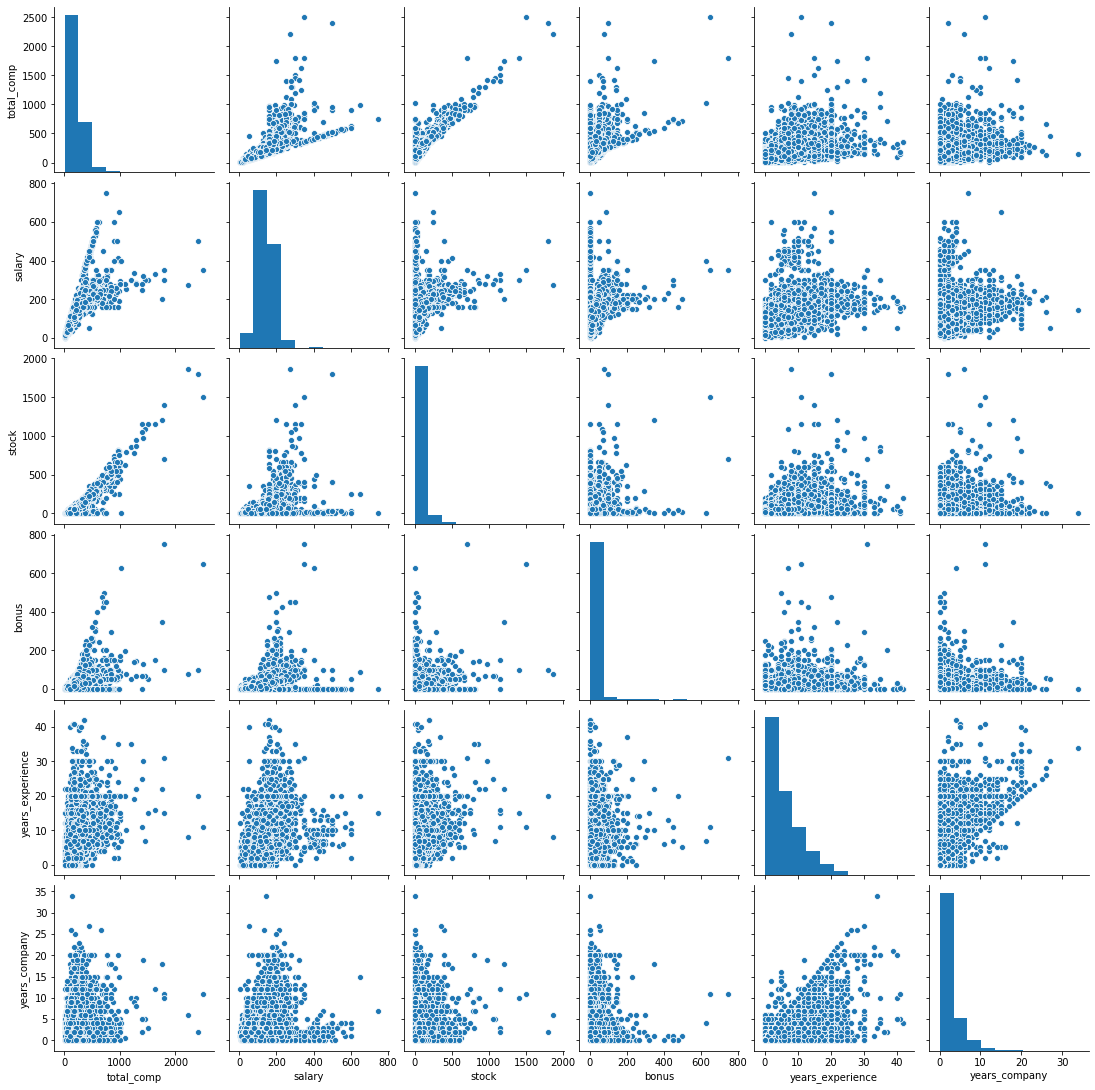

In [245]:
sns.pairplot(comp_normalized)